# Generate processed data
Here we will combine the subset of reviews with their labels and associated property description to create a processed dataset.

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
# Which GEO to process?
GEO = "texas"

In [31]:
# load all the relevant data
DATA_FP = "../../data"
LABELS = pd.read_csv(DATA_FP + f"/labels/{GEO}_reviews_labels.csv")
SUBSET = pd.read_csv(DATA_FP + f"/filtered/{GEO}_reviews_filtered.csv")
LISTINGS = pd.read_csv(DATA_FP + f"/raw/{GEO}_listings.csv", encoding="unicode_escape", low_memory=False)

For now, we are dropping labels of "maybe". These are reviews we weren't sure about the label of. If we need more training data, we can revisit these reviews for labeling.

In [32]:
maybes = LABELS[LABELS.label == "maybe"]
print(f"Number of maybe reviews: {len(maybes)}/{len(LABELS)}")

LABELS = LABELS[LABELS.label != "maybe"]

Number of maybe reviews: 11/633


Join datasets together.

In [33]:
# join with labels
subset_with_labels = pd.merge(LABELS, SUBSET, on="id", suffixes=("_labels", "_subset"))

# join with listings
subset_labels_and_listing = pd.merge(subset_with_labels, LISTINGS, left_on="listing_id", right_on="id", suffixes=("","_listings"))

Keep only the columns we need for the processed dataset. Also, rename the columns to be more descriptive, and clean the amentities column.

In [34]:
cols_to_keep =[
    "id",
    "listing_id",
    "description",
    "comments",
    "sentiment",
    "label",
    "name",
    "amenities"
]

subset_labels_and_listing = subset_labels_and_listing[cols_to_keep]

# rename id to review_id, for clarity
subset_labels_and_listing = subset_labels_and_listing.rename(columns={"id": "review_id"})

def parse_amenities(amenities):
  amenities = amenities.replace("{", "").replace("]", "").replace('"', "")
  return amenities.split(",")

subset_labels_and_listing.amenities = subset_labels_and_listing.amenities.apply(parse_amenities)

subset_labels_and_listing

,review_id,listing_id,description,comments,sentiment,label,name,amenities
0,83097,5456,Fabulous location for walking to Convention Ce...,"Sylvia was very nice, informal, and she was re...",4.333333,no,"Walk to 6th, Rainey St and Convention Ctr","[TV, Wifi, Air conditioning, Kitchen, Pets liv..."
1,133337,5456,Fabulous location for walking to Convention Ce...,Sylvia picked me up from the airport and gave ...,4.000000,no,"Walk to 6th, Rainey St and Convention Ctr","[TV, Wifi, Air conditioning, Kitchen, Pets liv..."
2,150928,5456,Fabulous location for walking to Convention Ce...,We had a lovely time in Austin and enjoyed the...,3.000000,no,"Walk to 6th, Rainey St and Convention Ctr","[TV, Wifi, Air conditioning, Kitchen, Pets liv..."
3,2706775,5456,Fabulous location for walking to Convention Ce...,Sylvia was an excellent host. Stayed in touch ...,4.500000,no,"Walk to 6th, Rainey St and Convention Ctr","[TV, Wifi, Air conditioning, Kitchen, Pets liv..."
4,8602878,5456,Fabulous location for walking to Convention Ce...,The place was a cute little self contained cot...,4.000000,no,"Walk to 6th, Rainey St and Convention Ctr","[TV, Wifi, Air conditioning, Kitchen, Pets liv..."
...,...,...,...,...,...,...,...,...
617,243926779,785270,"This cozy, sun-filled apartment in a quiet Cen...","Location is really nice, right in the Muller a...",3.250000,no,"The Darlington Arms, Central Austin","[TV, Cable TV, Internet, Wifi, Air conditionin..."
618,138631555,785963,Come stay in this cozy cottage featuring a ful...,Katy and Rick were absolutely lovely! I arrive...,4.500000,yes,Bouldin Cottage,"[TV, Cable TV, Internet, Wifi, Air conditionin..."
619,201595726,785963,Come stay in this cozy cottage featuring a ful...,Not in the good part of Bouldin. Filthy. After...,1.000000,yes,Bouldin Cottage,"[TV, Cable TV, Internet, Wifi, Air conditionin..."
620,27786173,813709,This home is a full time vacation rental so yo...,Pete was a great host. While we didn't meet hi...,4.000000,no,Cozy Bright Hyde Park Guest House,"[TV, Cable TV, Internet, Wifi, Air conditionin..."


### Quick EDA on the processed dataset

% of data with label 'yes': 12.0


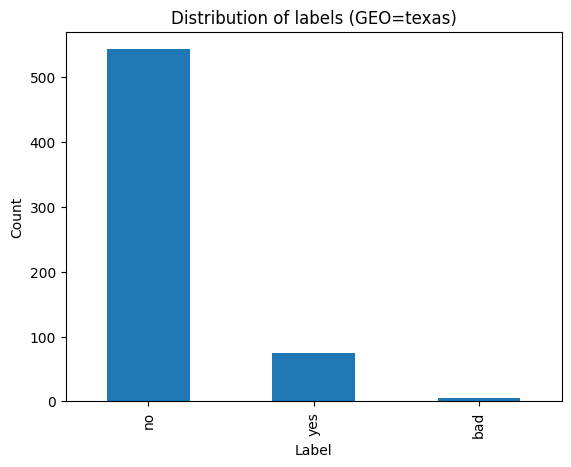

In [43]:
print(
    "% of data with label 'yes':", 
    round(len(subset_labels_and_listing[subset_labels_and_listing.label == "yes"])/len(subset_labels_and_listing), 2) * 100
)

fig = subset_labels_and_listing.label.value_counts().plot(kind="bar")
fig.set_title(f"Distribution of labels (GEO={GEO})")
fig.set_xlabel("Label")
fig.set_ylabel("Count")
plt.show()

In [46]:
# save it
subset_labels_and_listing.to_csv(DATA_FP + f"/processed/{GEO}_processed.csv", index=False)